In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
import sklearn



%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import pymc3 as pm
import theano.tensor as T
import theano

from scipy.stats import mode, chisquare

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import lasagne

from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

from pymc3 import Normal,Metropolis, sample,find_MAP   

In [2]:
# read flash.dat to a list of lists
datContent = [i.strip().split() for i in open("DES_full_wavelets.dat").readlines()]
datContent1 = [i.strip().split() for i in open("key.txt").readlines()]
columns=datContent[0]
columns1=datContent1[0]

In [3]:
features = pd.DataFrame(datContent[1:], columns=columns)
features=features.drop(['Object'], axis=1)
features.head()

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C12,C13,C14,C15,C16,C17,C18,C19,C20,z
0,-25.00037477444413,306.79211490489143,356.8997649727597,36.56806414373808,81.96294271832443,62.84881350054351,-149.50953399302256,49.388635007835,46.425898986402416,9.202334885218706,...,-33.037657156773214,-2.972694976441513,14.275091023477701,43.27783546040833,36.14978526004475,42.272794165931174,34.722632574076236,-1.0936417697512764,-35.21439165696788,0.3502
1,-238.79206891687346,155.3919979441455,211.36807494174155,-3.746101978293055,-93.19830815652585,42.334705719188065,-0.4838348067168141,130.21422038778377,-38.95153007406436,-21.025637471790123,...,73.82622017894873,65.57448246149349,-12.685975243515733,-6.071823311914481,8.494442815914777,-14.946762084511736,21.59773335882574,-11.420969334214146,1.7374948480963388,0.9609
2,-542.521162149438,70.30591950576184,83.55855291754986,-62.43710158940596,-4.303015725470706,13.865165481969552,-10.760797295484963,27.974491688346184,-2.373651075888283,17.846619786960538,...,6.706933251134956,11.655275670677133,5.120015670925272,-12.657090739176272,-3.9683953727566843,-4.338903653156308,16.50174347535103,10.526471774932752,-8.92679194932048,0.5628
3,-209.04457680773876,-121.1521579037945,59.6778141143199,22.282682854904284,-134.8065942940524,-18.231881130250255,-10.396626106209759,31.89273041660975,24.781259200927778,-25.653730436879304,...,10.092535994029824,2.115467645344072,69.00457558938463,28.33006929131822,-22.327955845622725,-14.938633312832923,6.709835775927774,-9.719449198277808,5.925270987983696,0.4747
4,-448.45014262661607,130.38673932244154,-59.986039979245646,60.42144611544627,-38.94952538238488,-29.11613660545993,39.45988907037251,-27.08410046683938,-23.877828822879913,17.637273025995523,...,33.72356414146945,-36.80300636482759,-3.5666978828339744,3.297053642332119,17.83264974893807,-41.45221511454384,-8.489533409627624,14.044875152417134,8.466453914603711,0.8882


In [4]:
labels = pd.DataFrame(datContent1[1:], columns=columns1)
labels.loc[labels['Type']=='3', 'Type']=0
labels.loc[labels['Type']=='2', 'Type']=0
labels.loc[labels['Type']=='1', 'Type']=1
labels=labels.drop(['Object'], axis=1)
labels.head()

,Type
0,0
1,0
2,0
3,0
4,0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(features.values.astype(np.float64), labels.values.astype(np.float64), test_size=.25)
y_train = y_train.ravel()
y_test = y_test.ravel()

In [6]:
scaler = StandardScaler()
scaler.fit(X_train)


X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
input_var = theano.shared(X_train[:500,...].astype(np.float64))
target_var = theano.shared(y_train[:500,...].astype(np.float64))

In [8]:
def build_ann(init):
    l_in = lasagne.layers.InputLayer(shape=features.shape,
                                     input_var=input_var)

    # Add a fully-connected layer of 800 units, using the linear rectifier, and
    # initializing weights with Glorot's scheme (which is the default anyway):
    n_hid1 = 22
    l_hid1 = lasagne.layers.DenseLayer(
        l_in, num_units=n_hid1,
        nonlinearity=lasagne.nonlinearities.tanh,
        b=init,
        W=init
    )

    n_hid2 = 22
    # Another 800-unit layer:
    l_hid2 = lasagne.layers.DenseLayer(
        l_hid1, num_units=n_hid2,
        nonlinearity=lasagne.nonlinearities.tanh,
        b=init,
        W=init
    )

    # Finally, we'll add the fully-connected output layer, of 10 softmax units:
    l_out = lasagne.layers.DenseLayer(
        l_hid2, num_units=10,
        nonlinearity=lasagne.nonlinearities.softmax,
        b=init,
        W=init
    )
    
    prediction = lasagne.layers.get_output(l_out)
    
    # 10 discrete output classes -> pymc3 categorical distribution
    out = pm.Categorical('out', 
                         prediction,
                         observed=target_var)
    
    return out


In [9]:


class GaussWeights(object):
    def __init__(self):
        self.count = 0
    def __call__(self, shape):
        self.count += 1
        return pm.Normal('w%d' % self.count, mu=0, sd=.1, 
                         testval=np.random.normal(size=shape).astype(np.float64),
                         shape=shape)



In [10]:
from six.moves import zip

# Tensors and RV that will be using mini-batches
minibatch_tensors = [input_var, target_var]

# Generator that returns mini-batches in each iteration
def create_minibatch(data, batchsize=500):
    
    rng = np.random.RandomState(0)
    start_idx = 0
    while True:
        # Return random data samples of set size batchsize each iteration
        ixs = rng.randint(data.shape[0], size=batchsize)
        yield data[ixs]

minibatches = zip(
    create_minibatch(X_train, 500),
    create_minibatch(y_train, 500),
)

total_size = len(y_train)

def run_advi(likelihood, advi_iters=50000):
    # Train on train data
    input_var.set_value(X_train[:500, ...])
    target_var.set_value(y_train[:500, ...])
    
    v_params = pm.variational.advi_minibatch(
        n=advi_iters, minibatch_tensors=minibatch_tensors, 
        minibatch_RVs=[likelihood], minibatches=minibatches, 
        total_size=total_size, learning_rate=1e-2, epsilon=1.0
    )
    trace = pm.variational.sample_vp(v_params, draws=500)
    
    # Predict on test data
    input_var.set_value(X_test)
    target_var.set_value(y_test)
    
    ppc = pm.sample_ppc(trace, samples=100)
    y_pred = mode(ppc['out'], axis=0).mode[0, :]
    
    return v_params, trace, ppc, y_pred


In [11]:
with pm.Model() as neural_network:
    likelihood = build_ann(GaussWeights())
    v_params, trace, ppc, y_pred = run_advi(likelihood)




RuntimeError: cannot initialize parameters: the provided callable did not return an array-like value

In [20]:

def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(features.shape[1], n_hidden).astype(float)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(float)
    init_out = np.random.randn(n_hidden).astype(float)
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(features.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Categorical('out', 
                           act_out,
                           observed=ann_output,
                           total_size=y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

#    out = pm.Categorical('out', 
#                         prediction,
#                         observed=target_var)
    

# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.

input_var = theano.shared(X_train[:500,...].astype(np.float64))
target_var = theano.shared(y_train[:500,...].astype(np.float64))

ann_input = theano.shared(X_train.astype(np.float64))
ann_output = theano.shared(y_train.astype(np.float64))
neural_network = construct_nn(ann_input, ann_output)



In [21]:
with neural_network:
    mu2 = pm.Normal("mu2", mu=0, sd=1, shape=10)
    

with neural_network:
    step2 = pm.Metropolis([mu2])
    trace1 = pm.sample(1000, init=None, step=[step2], cores=2, tune=1000) 

Assigned NUTS to w_in_1
Assigned NUTS to w_1_2
Assigned NUTS to w_2_out


ValueError: Input dimension mis-match. (input[0].shape[0] = 150, input[1].shape[0] = 140)

In [12]:
%time
with neural_network:
    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step=step,start=start,tune=1000)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.4 µs
Optimization terminated successfully.
         Current function value: -669.684935
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5


100%|██████████| 2000/2000 [00:02<00:00, 843.43it/s]


In [14]:
with neural_network:
    ppc = pm.sample_ppc(trace, samples=500)

100%|██████████| 500/500 [00:00<00:00, 118136.10it/s]


In [16]:
trace

<MultiTrace: 1 chains, 1000 iterations, 1 variables>

In [31]:
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)

def reliability_curve(y_true, y_score, bins=10, normalize=False):

    if normalize:  # Normalize scores into bin [0, 1]
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())

    bin_width = 1.0 / bins
    bin_centers = np.linspace(0, 1.0 - bin_width, bins) + bin_width / 2

    y_score_bin_mean = np.empty(bins)
    empirical_prob_pos = np.empty(bins)
    for i, threshold in enumerate(bin_centers):
        # determine all samples where y_score falls into the i-th bin
        bin_idx = np.logical_and(threshold - bin_width / 2 < y_score,
                                 y_score <= threshold + bin_width / 2)
        # Store mean y_score and mean empirical probability of positive class
        y_score_bin_mean[i] = y_score[bin_idx].mean()
        empirical_prob_pos[i] = y_true[bin_idx].mean()
    return y_score_bin_mean, empirical_prob_pos

/home/tumisang/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb02cbfdd68>,
      dtype=object)

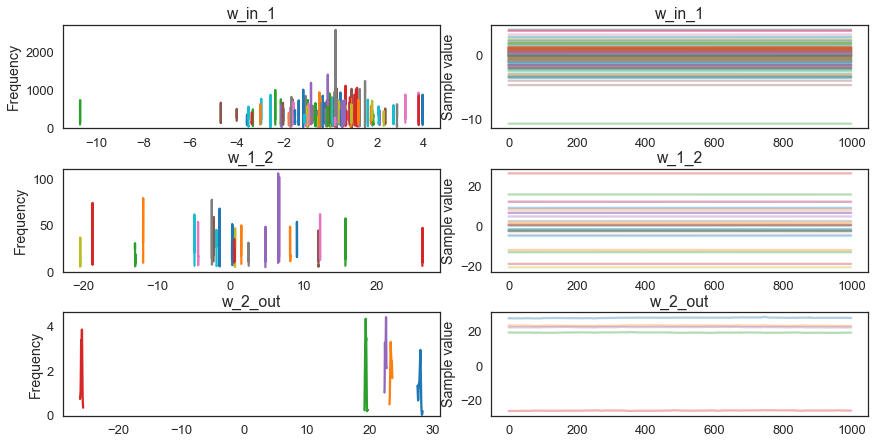

In [34]:
pm.traceplot(trace)

In [31]:
import sklearn
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_test)

In [12]:
X_train.shape  , X_test.shape , y_train.shape , y_test.shape

((15989, 22), (5330, 22), (15989, 1), (5330, 1))

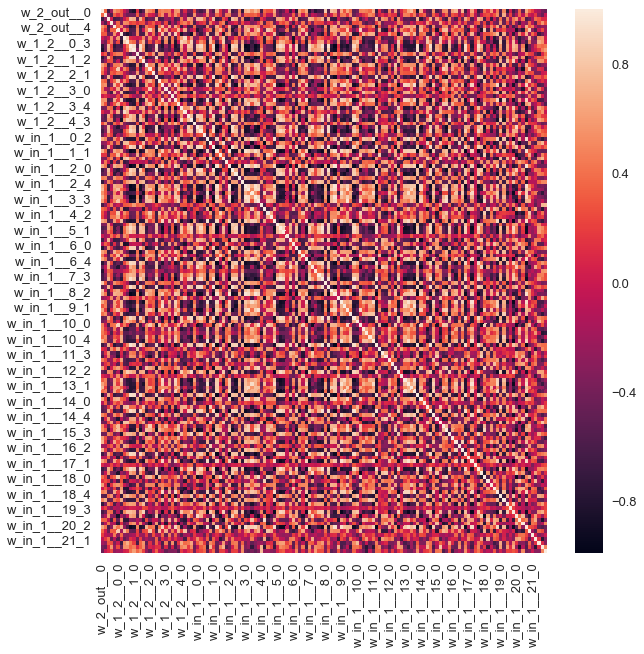

In [30]:
df=pm.trace_to_dataframe(trace)
dcor=df.corr()

plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 1})
sns.heatmap(dcor)

In [36]:
df_trace = pm.trace_to_dataframe(trace)
ws =(df_trace[-1000//2:].mean(0))[3:6]

def predict(x_new,ws = ws):
      theta = (pm.math.dot(x_new,ws))    
      return pm.math.exp(theta)/100

test_x = np.array([0,1,0])
test_y = predict(test_x)

In [39]:
def predict(A, B, X):
    Y_pred = A.mean(axis=0) + np.dot(X, B.mean(axis=0))
    p = np.exp(Y_pred).T/np.sum(np.exp(Y_pred), axis=1)
    p_class = np.argmax(p, axis=0)
    return p, p_class

In [8]:
mode?

In [ ]:
predict()